# **1. Library**

In [ ]:
import os
import gc
import pickle
import datetime
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
!pip3 install catboost
import catboost as cb
from catboost import CatBoostRegressor

from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

     |████████████████████████████████| 69.2MB 97kB/s 


In [ ]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

# **2. Merge data**

## **2.1. Read data**

In [ ]:
# Read data # change here
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/test.csv')
hist_feats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/hist_transac.csv')
new_feats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/new_transac.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(hist_feats.shape)
print(new_feats.shape)

(201917, 6)
(123623, 5)
(325540, 231)
(290001, 197)


In [ ]:
# fillna
test['first_active_month'].fillna('2017-09', inplace=True)

In [ ]:
# Gộp data
train = train.merge(hist_feats, on=['card_id'], how='left')
test = test.merge(hist_feats, on=['card_id'], how='left')

train = train.merge(new_feats, on=['card_id'], how='left')
test = test.merge(new_feats, on=['card_id'], how='left')

In [ ]:
print(train.shape)
print(test.shape)

(201917, 432)
(123623, 431)


## **2.2. Features related to hist and new**

In [ ]:
# historical / new transaction interaction
for df in [train, test]:
    df['new_hist_transac_amount_sum_ratio'] = df['new_transac_amount_sum'].values / df['hist_transac_amount_sum'].values
    df['new_hist_transac_amount_max_ratio'] = df['new_transac_amount_max'].values / df['hist_transac_amount_max'].values
    df['new_hist_transac_amount_sum_log_ratio'] = np.log2(df['new_hist_transac_amount_sum_ratio'])
    df['new_hist_transac_amount_max_log_ratio'] = np.log2(df['new_hist_transac_amount_max_ratio'])
  
    df['installment_total_sum'] = df['hist_transac_installments_sum'].values + df['new_transac_installments_sum'].values
    
    for i in range(1, 7):
        for j in range(1, 3):
            df['new_hist_purchase_amount_ratio_{}_{}'.format(i, j)] = df['new_transac_monthlag_last_{}_amount'.format(j)] / df['hist_transac_monthlag_last_{}_amount'.format(i)]
            df['new_hist_purchase_amount_log_ratio_{}_{}'.format(i, j)] = np.log2(df['new_hist_purchase_amount_ratio_{}_{}'.format(i, j)])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## **2.3. Prepare features for model**

In [ ]:
# outlier
is_outlier = train['target'] < -20.

# time related
for df in [train, test]:
    df['first_active_year'] = df['first_active_month'].astype(str).apply(lambda x: x[:4])
    df['first_active_mon'] = df['first_active_month'].astype(str).apply(lambda x: x[-2:])

lbl_encoder = LabelEncoder()
for c in ['first_active_year', 'first_active_mon']:
    train[c] = lbl_encoder.fit_transform(train[c].astype(str))
    test[c] = lbl_encoder.fit_transform(test[c].astype(str))

In [ ]:
# categorical feature
features_full = train.columns.tolist()
features_categorical = ['feature_1', 'feature_2', 'feature_3', 'first_active_year', 'first_active_mon']

# remove feature
target = 'target'
for c in ['target', 'card_id', 'first_active_month', 'hist_purchase_date_first','hist_purchase_date_last', 'new_purchase_date_last', 'new_purchase_date_first']:
    features_full.remove(c)

In [ ]:
train.replace([-np.inf, np.inf], np.nan, inplace=True) 
test.replace([-np.inf, np.inf], np.nan, inplace=True) 

In [ ]:
for df in [train, test]:
    for c in df.columns[df.isnull().sum() != 0].values:
        if c in features_full and c not in features_categorical:
            df[c].fillna(df[c].median(), inplace=True)

# **3. Model**

## **3.1. LightGBM**

### **3.1.1. gbdt**

In [ ]:
param =  {"objective" : "regression", 
          "boosting" : "gbdt", 
          "metric" : "rmse",  
          "max_depth": 9, 
          "min_data_in_leaf": 70, 
          "min_gain_to_split": 0.05,
          "reg_alpha": 0.1, 
          "reg_lambda": 20, 
          "num_leaves" : 120,
          "max_bin" : 350,
          "learning_rate" : 0.005, 
          "bagging_fraction" : 1,
          "bagging_freq" : 1,
          "feature_fraction" : 0.2, 
          "verbosity": -1}

# prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

# run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, is_outlier)):
    print("fold {}".format(fold_))

    trn_data = lgb.Dataset(train.iloc[trn_idx][features_full], label=train.iloc[trn_idx][target], feature_name=features_full, categorical_feature=features_categorical)
    val_data = lgb.Dataset(train.iloc[val_idx][features_full], label=train.iloc[val_idx][target], feature_name=features_full, categorical_feature=features_categorical)
 
    clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], num_boost_round=10000, early_stopping_rounds=200, verbose_eval=100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features_full], num_iteration=clf.best_iteration)
    
    # predictions
    predictions += clf.predict(test[features_full], num_iteration=clf.best_iteration) / folds.n_splits

    # importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = features_full 
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

print('CV RMSE = {:.6f}'.format(rmse(oof, train[target])))
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/sample_submission.csv')
sub['target'] = predictions
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/lgb_sub_1.csv', index=False)

fold 0


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71536	valid_1's rmse: 3.75358
[200]	training's rmse: 3.62829	valid_1's rmse: 3.70791
[300]	training's rmse: 3.56605	valid_1's rmse: 3.68399
[400]	training's rmse: 3.51817	valid_1's rmse: 3.67101
[500]	training's rmse: 3.47938	valid_1's rmse: 3.66381
[600]	training's rmse: 3.44605	valid_1's rmse: 3.65866
[700]	training's rmse: 3.41796	valid_1's rmse: 3.65541
[800]	training's rmse: 3.39374	valid_1's rmse: 3.65374
[900]	training's rmse: 3.37295	valid_1's rmse: 3.65248
[1000]	training's rmse: 3.35365	valid_1's rmse: 3.65151
[1100]	training's rmse: 3.33586	valid_1's rmse: 3.65047
[1200]	training's rmse: 3.31793	valid_1's rmse: 3.64974
[1300]	training's rmse: 3.30195	valid_1's rmse: 3.64928
[1400]	training's rmse: 3.28677	valid_1's rmse: 3.64899
[1500]	training's rmse: 3.27311	valid_1's rmse: 3.64877
[1600]	training's rmse: 3.25991	valid_1's rmse: 3.64827
[1700]	training's rmse: 3.24797	valid_1's rmse: 3.

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Text(0.5, 1.0, 'LGB Features (avg over folds)')

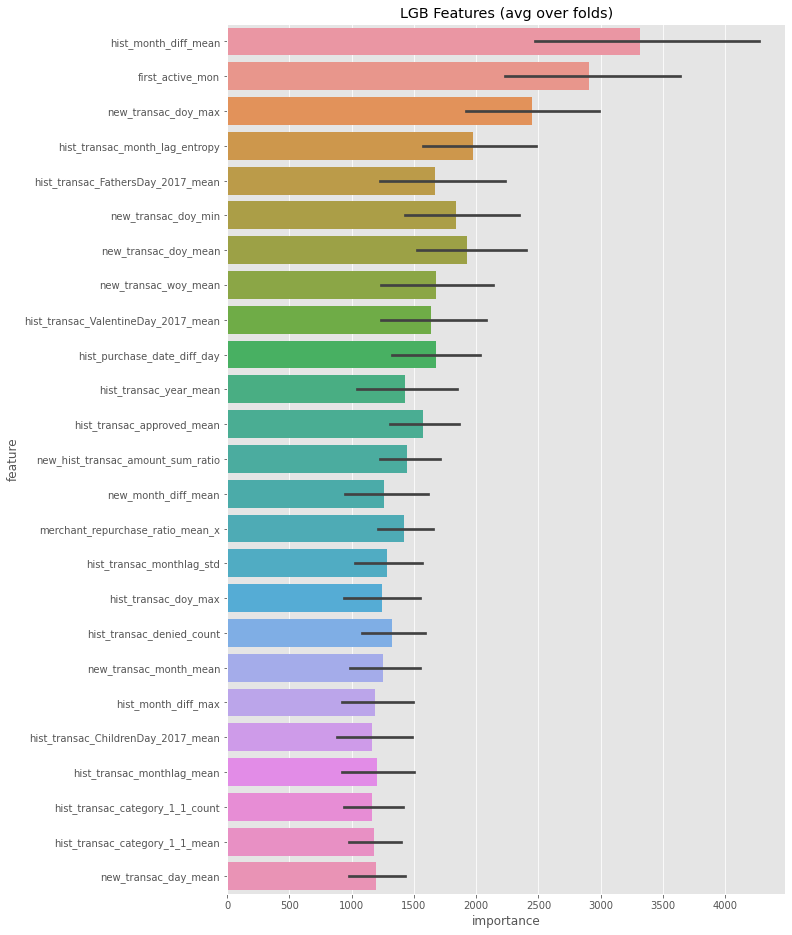

In [ ]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:25].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(10, 16));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

In [ ]:
feature_importance[feature_importance['feature'] == 'first_active_mon']

,feature,importance,fold
455,first_active_mon,2709,1
455,first_active_mon,1923,2
455,first_active_mon,2308,3
455,first_active_mon,3279,4
455,first_active_mon,4330,5


In [ ]:
pred = pd.DataFrame()
pred['y'] = train[target].values
pred['y pred'] = oof
pred.head()

,y,y pred
0,-0.820283,-0.354956
1,0.392913,-0.644147
2,0.688056,0.424211
3,0.142495,0.164852
4,-0.159749,-0.103807


In [ ]:
rmse(pred['y'], pred['y pred'])

3.6452963076888807

In [ ]:
pred['sub'] = np.abs(pred['y'] - pred['y pred'])

In [ ]:
pred.head()

,y,y pred,sub
0,-0.820283,-0.354956,0.465326
1,0.392913,-0.644147,1.037060
2,0.688056,0.424211,0.263845
3,0.142495,0.164852,0.022357
4,-0.159749,-0.103807,0.055942


In [ ]:
pred[pred['y'] == -33.21928095].sort_values(by='sub', ascending=False)

,y,y pred,sub
64388,-33.219281,2.502227,35.721508
103765,-33.219281,2.224276,35.443557
10958,-33.219281,1.797710,35.016991
98544,-33.219281,1.635158,34.854439
169147,-33.219281,1.617268,34.836549
...,...,...,...
12602,-33.219281,-16.002926,17.216355
79732,-33.219281,-16.272342,16.946939
186912,-33.219281,-16.602099,16.617182
25347,-33.219281,-17.425954,15.793327



## **3.2. CatBoost**

In [ ]:
train_data = train[features_full]
train_labels = train[target]
test_data = test[features_full]

In [ ]:
cate_idx = []
for i in features_categorical:
  cate_idx.append(train_data.columns.get_loc(i))
cate_idx

[0, 1, 2, 454, 455]

In [ ]:
# prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
oof_cat = np.zeros(len(train))
predictions_cat = np.zeros(len(test))
feature_importance_cat = pd.DataFrame()

# run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, is_outlier)):
    print("fold {}".format(fold_))

    X_train = train_data.loc[trn_idx]
    y_train = train_labels.loc[trn_idx]
    X_valid = train_data.loc[val_idx]
    y_valid = train_labels.loc[val_idx]

    model = CatBoostRegressor(iterations=500,  eval_metric='RMSE', learning_rate=0.02, depth=13, l2_leaf_reg=10, bootstrap_type='Bernoulli', od_type='Iter', od_wait=50, random_seed=11, allow_writing_files=False)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], cat_features=cate_idx, use_best_model=True, verbose=100)
    oof_cat[val_idx] = model.predict(X_valid)
    
    # predictions
    predictions_cat += model.predict(test_data) / folds.n_splits

    # importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = features_full 
    fold_importance["importance"] = model.get_feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance_cat = pd.concat([feature_importance_cat, fold_importance], axis=0)

print('CV RMSE = {:.6f}'.format(rmse(oof_cat, train[target])))
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/sample_submission.csv')
sub['target'] = predictions_cat
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/viettel/data/cat_sub_1.csv', index=False)

fold 0
0:	learn: 3.8459574	test: 3.8459574	test1: 3.8434164	best: 3.8434164 (0)	total: 1.64s	remaining: 13m 37s
100:	learn: 3.5397903	test: 3.5397903	test1: 3.7040055	best: 3.7040055 (100)	total: 2m 25s	remaining: 9m 34s
200:	learn: 3.4056596	test: 3.4056596	test1: 3.6805908	best: 3.6805635 (199)	total: 4m 39s	remaining: 6m 55s
300:	learn: 3.3187493	test: 3.3187785	test1: 3.6731456	best: 3.6730650 (297)	total: 6m 52s	remaining: 4m 32s
400:	learn: 3.2465248	test: 3.2465624	test1: 3.6685704	best: 3.6685704 (400)	total: 9m 9s	remaining: 2m 15s
499:	learn: 3.1855503	test: 3.1856067	test1: 3.6660036	best: 3.6659198 (496)	total: 11m 27s	remaining: 0us

bestTest = 3.665919765
bestIteration = 496

Shrink model to first 497 iterations.
fold 1
0:	learn: 3.8427402	test: 3.8427402	test1: 3.8558496	best: 3.8558496 (0)	total: 1.52s	remaining: 12m 37s
100:	learn: 3.5387662	test: 3.5387662	test1: 3.7131469	best: 3.7131469 (100)	total: 2m 18s	remaining: 9m 6s
200:	learn: 3.4017342	test: 3.4017342	test1

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Text(0.5, 1.0, 'LGB Features (avg over folds)')

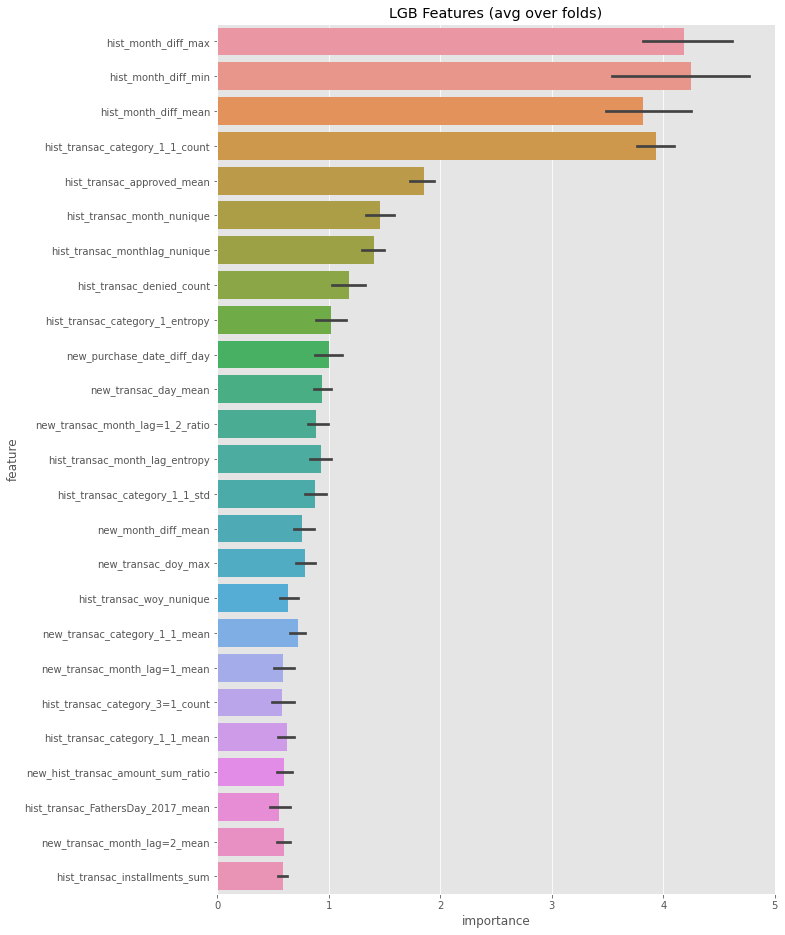

In [ ]:
cols = feature_importance_cat[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:25].index
best_features = feature_importance_cat.loc[feature_importance_cat.feature.isin(cols)]
plt.figure(figsize=(10, 16));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')